In [1]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2
import os
from collections import Counter
import xml.etree.ElementTree as ET
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

slim = tf.contrib.slim

/nfshome/xueqin/anaconda3/envs/ge/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import sys
sys.path.append('../')

In [4]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [5]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

In [6]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NCHW'#NHWC
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = '/nfshome/xueqin/udalearn/shibai/checkpoints/ssd_300_vgg.ckpt'
#ckpt_filename = '/nfshome/xueqin/udalearn/data/VOCdevkit/result2/model.ckpt-5000'
# ckpt_filename = '/nfshome/xueqin/udalearn/BeerData/tmp/logs/old_output/log1/model.ckpt-10455'

isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

==== (1, 3, 300, 300)
INFO:tensorflow:Restoring parameters from /nfshome/xueqin/udalearn/shibai/checkpoints/ssd_300_vgg.ckpt


In [7]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)#21
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

In [ ]:
def read_xml(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    size = root.find('size')
    shape = [int(size.find('height').text),
             int(size.find('width').text),
             int(size.find('depth').text)]

    labels = []
    labels_text = []
    gt_boxes = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(int(VOC_LABELS[label][0]))
        labels_text.append(label.encode('ascii'))
        bbox = obj.find('bndbox')
        gt_boxes.append((float(bbox.find('ymin').text) / shape[0],
                       float(bbox.find('xmin').text) / shape[1],
                       float(bbox.find('ymax').text) / shape[0],
                       float(bbox.find('xmax').text) / shape[1]
                       ))

    return labels, gt_boxes
def calcIOU(one_x, one_y, one_w, one_h, two_x, two_y, two_w, two_h):  
    if((abs(one_x - two_x) < ((one_w + two_w) / 2.0)) and (abs(one_y - two_y) < ((one_h + two_h) / 2.0))):  
        lu_x_inter = max((one_x - (one_w / 2.0)), (two_x - (two_w / 2.0)))  
        lu_y_inter = min((one_y + (one_h / 2.0)), (two_y + (two_h / 2.0)))  
  
        rd_x_inter = min((one_x + (one_w / 2.0)), (two_x + (two_w / 2.0)))  
        rd_y_inter = max((one_y - (one_h / 2.0)), (two_y - (two_h / 2.0)))  
  
        inter_w = abs(rd_x_inter - lu_x_inter)  
        inter_h = abs(lu_y_inter - rd_y_inter)  
  
        inter_square = inter_w * inter_h  
        union_square = (one_w * one_h) + (two_w * two_h) - inter_square  
  
        calcIOU = inter_square / union_square * 1.0  
    return calcIOU

def get_acc(resul_, gt_, jj=0):
    # 预测错误，没有对应类的结果，或者预测错误，图中这一类个数为0，所以对于这一类acc =0
    if resul_[jj]==0 or gt_[jj] == 0:
        acc_ = 0
#     如果预测的结果多余 真实的结果，acc=1
    elif resul_[jj]>= gt_[jj]:
        acc_ = 1.
#     其他，这一类的acc=预测数量/gt数量
    else:
        acc_ = resul_[jj]/gt_[jj]
    return acc_

def output_acc(acc, bboxes, resul, gt):
    #print(bboxes)
#   传入已经存在的acc，这个acc为map
    for i in range(1, len(acc)):
        # acc长度为21，0为背景，1～21类。对于每一类计算acc
        acc_ = get_acc(resul, gt, jj=i)
#       如果原始为0，acc直接为计算结果acc_
        if acc[i] == 0:
            acc[i] = acc_
#       如果acc 不为0，更新平均acc  
        if acc_ != 0:
            acc[i] = (acc[i] + acc_)/2
        
    return acc
###########3
def cal_average_pre(acc, rclasses, bboxes, gt_class, gt_box):
    for i in range(1, len(acc)):
        for val in rclasses:
            if val == i :
                print(" ",i)

In [ ]:
VOC_LABELS = {
    'none': (0, 'Background'),
    'aeroplane': (1, 'Vehicle'),
    'bicycle': (2, 'Vehicle'),
    'bird': (3, 'Animal'),
    'boat': (4, 'Vehicle'),
    'bottle': (5, 'Indoor'),
    'bus': (6, 'Vehicle'),
    'car': (7, 'Vehicle'),
    'cat': (8, 'Animal'),
    'chair': (9, 'Indoor'),
    'cow': (10, 'Animal'),
    'diningtable': (11, 'Indoor'),
    'dog': (12, 'Animal'),
    'horse': (13, 'Animal'),
    'motorbike': (14, 'Vehicle'),
    'person': (15, 'Person'),
    'pottedplant': (16, 'Indoor'),
    'sheep': (17, 'Animal'),
    'sofa': (18, 'Indoor'),
    'train': (19, 'Vehicle'),
    'tvmonitor': (20, 'Indoor'),
}

dir_path = '/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages'
xml_path = '/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/Annotations'

file_path = sorted(os.listdir(dir_path))
# 初始化map，全为0
acc = np.zeros([21])

# for j in range(len(file_path)):#20
#     #test图片地址
#     image_path = os.path.join(dir_path, file_path[j])
#     #对应xml文件地址
#     xml_file = os.path.join(xml_path, file_path[j][:6]+str('.xml'))
#     #获取gt，图片中存在object的类别和对应个数
#     object_label = Counter(read_xml(xml_file))
# #     读图
#     img = mpimg.imread(image_path)
# #     网络跑结果，获取分类
#     rclasses, _, _ =  process_image(img)
#     rclasses_ = Counter(rclasses)
#     #print(rclasses_, object_label)
# #     计算map
#     out = output_acc(acc, rclasses_, object_label)
for j in range(20):
    image_path = os.path.join(dir_path, file_path[j])
    xml_file = os.path.join(xml_path, file_path[j][:6]+str('.xml'))

    gt_class, gt_box = read_xml(xml_file)
    object_label = Counter(gt_class)
    img = mpimg.imread(image_path)
    rclasses, _, bboxes=  process_image(img)
    out = cal_average_pre(acc, rclasses, bboxes, gt_class, gt_box)
# rclasses_ = Counter(rclasses)
# out = output_acc(acc, bboxes,rclasses_, object_label) 
# print("output",out)

In [46]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/000001.jpg'
img = mpimg.imread(path)
rclasses, rscores, rbboxes =  process_image(img)
# height=img.shape[0]
# width = img.shape[1]
# print(height, width)
# # print(rbboxes[0][0])
# ymin = int(rbboxes[0][0] * height)
# xmin = int(rbboxes[0][1] * width)
# ymax = int(rbboxes[0][2] * height)
# xmax = int(rbboxes[0][3] * width)
# print(ymin, xmin, ymax, xmax)
print(rclasses, rbboxes)
print(rclasses[1], rbboxes[1])
#visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

[15 12] [[0.01001301 0.02060121 0.9883243  1.        ]
 [0.4676376  0.14045547 0.74221426 0.5653444 ]]
12 [0.4676376  0.14045547 0.74221426 0.5653444 ]


In [1]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/006631.jpg'
img = mpimg.imread(path)#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)
print(rclasses)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

NameError: name 'mpimg' is not defined

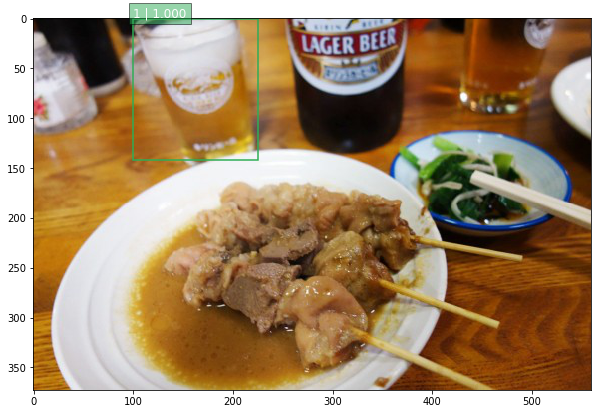

In [48]:
path='/nfshome/xueqin/udalearn/data/VOCdevkit/VOC2007/JPEGImages/004977.jpg'
# path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/baidu_130.jpeg''
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)
#print(type(rclasses), rscores, rbboxes)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

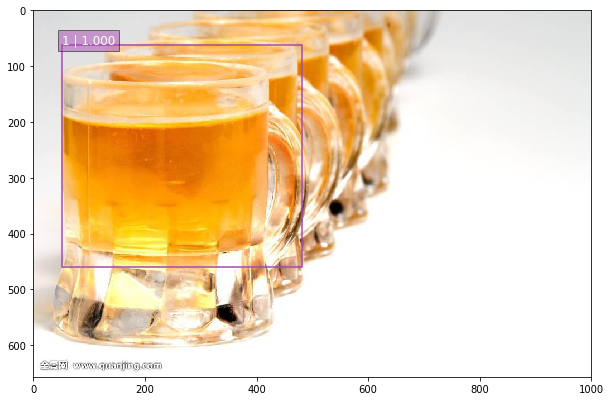

In [38]:
# path='/nfshome/xueqin/udalearn/BeerData/JPEGImages/139.jpg'
path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/Baidu_606.jpeg'
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

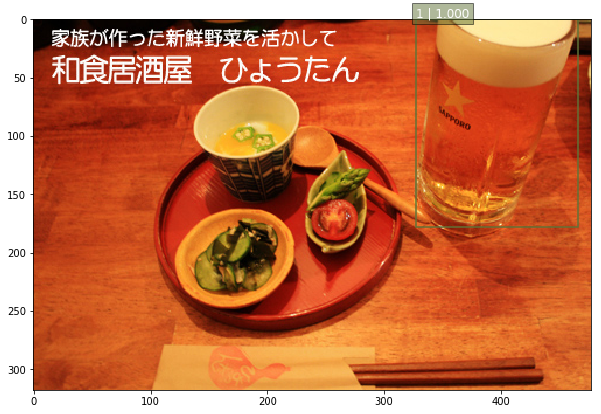

In [39]:
path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/Bing_458.jpeg'
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

[[ 0.41373584  0.41153803  0.75597692  0.73916757]]


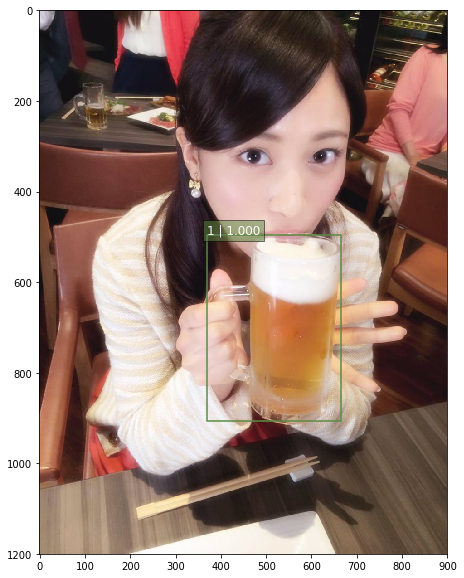

In [43]:
path='/nfshome/xueqin/udalearn/BeerData/JPEGImages/1725.jpg'
# path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/baidu_130.jpeg''
img = mpimg.imread(path )#+ image_names[23])

rclasses, rscores, rbboxes =  process_image(img)
print(rbboxes)
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

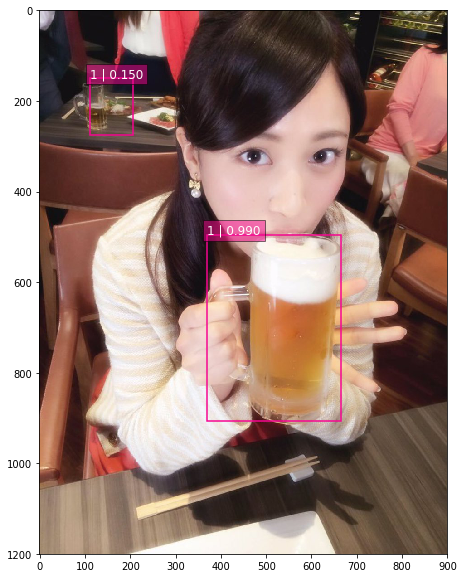

In [69]:
path='/nfshome/xueqin/udalearn/BeerData/JPEGImages/1725.jpg'
# path = '/nfshome/xueqin/udalearn/BeerData/test/all_beer/baidu_130.jpeg''
img = mpimg.imread(path )#+ image_names[23])

rclasses=np.array([1,1])
rscores =  np.array([0.15, 0.99])
rbboxes = np.array([[ 0.125,0.123,0.23,0.230245118],
                    [ 0.41373584,0.41153803,0.75597692,0.73916757]])
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)